# Spase Coding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sparse_coding import SparseCodingModel
import tensorflow as tf

### Util Funcs

In [2]:
def create_images(n_samples, x_dim, y_dim):
    X = []
    for i in range(n_samples):
        img = np.zeros((x_dim, y_dim))
        x_bars = np.random.choice(np.arange(x_dim), np.random.randint(x_dim // 1.5), replace=False)
        y_bars = np.random.choice(np.arange(y_dim), np.random.randint(y_dim // 1.5), replace=False)
        y_bars = y_bars[:np.random.randint(y_dim)]
        for x in x_bars:
            img[x, :] += np.ones(y_dim)
        for y in y_bars:
            img[:, y] += np.ones(x_dim)
        img = img.reshape((x_dim * y_dim))
        X.append(img)

    return np.array(X)

In [3]:
# Gets MNIST images for a given number. (ie. if number=1, all images of 1 are returned)
def get_mnist_images(number=1):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    X = ((np.concatenate((x_train, x_test), axis = 0))).astype(float) 
    y = np.concatenate((y_train, y_test), axis = 0)

    # Isolate Ones
    digit = X[np.where(y == number)]
    digit = (digit.reshape((len(digit), 28*28))).astype(float)
    return digit

## Sparse Coding Model Class

### Train the Model

In [5]:
model = SparseCodingModel(256, 32, 0.001)

X_train = create_images(256, 16, 16)

model.train(X_train, num_steps=500)

100% (500 of 500) |######################| Elapsed Time: 0:01:58 Time:  0:01:58


### Feature Library

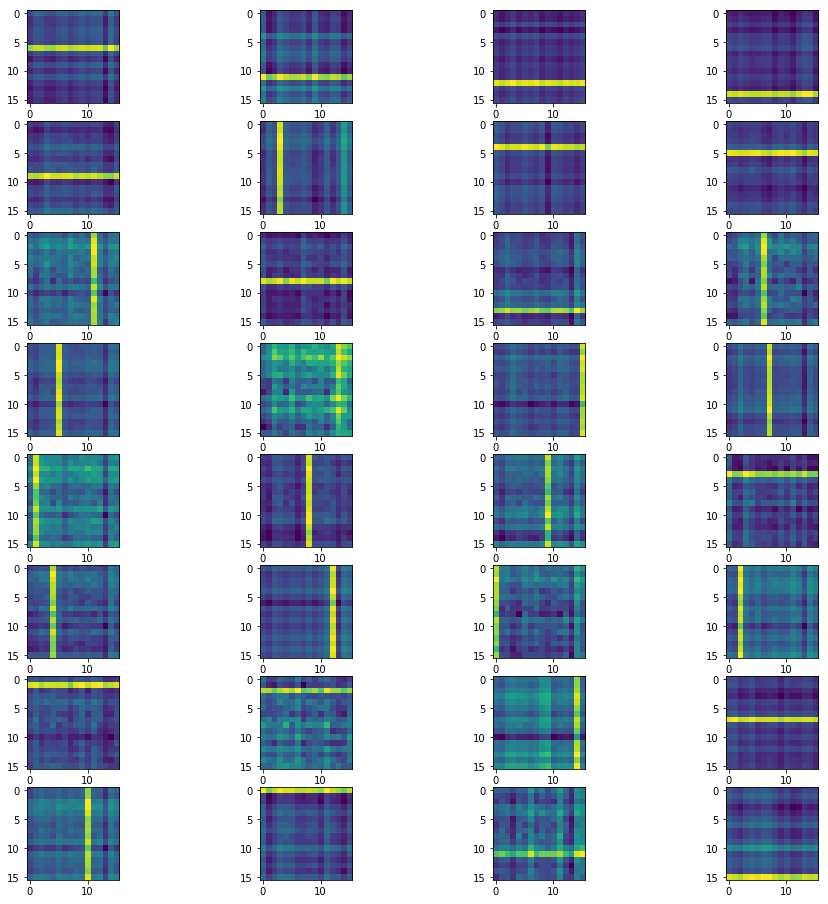

In [6]:
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 8
for i in range(32):
    img = model.Phi[:, i].reshape(16, 16)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)
plt.show()

### Predict Activations From Test Images

In [7]:
X_test = create_images(10, 16, 16)
activations = model.predict(X_test, num_steps=3000)

### Generate Images From Activations

In [8]:
X_pred = model.generate(activations)

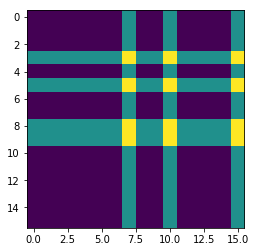

In [9]:
plt.imshow(X_test[7].reshape(16, 16))

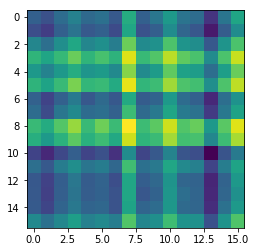

In [10]:
plt.imshow(X_pred[:, 7].reshape(16, 16))

## With Numbers

In [11]:
num_dataset = get_mnist_images(number=2)

In [12]:
num_dataset.shape

(6990, 784)

In [13]:
num_model = SparseCodingModel(200, 32, 0.005)
num_model.train(num_dataset[:200])

100% (2000 of 2000) |####################| Elapsed Time: 0:11:14 Time:  0:11:14


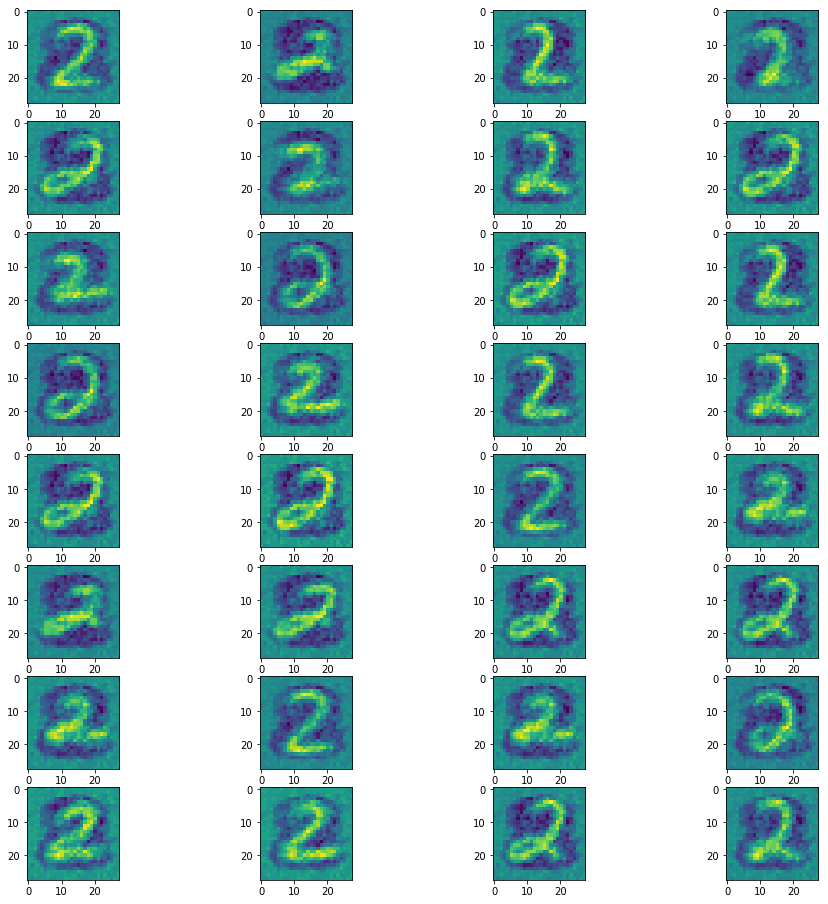

In [15]:
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 8
for i in range(32):
    img = num_model.Phi[:, i].reshape(28, 28)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)
plt.show()